<a href="https://colab.research.google.com/github/Renaud17/mesprojets/blob/master/EDA_Pr%C3%A9diction_de_d%C3%A9sabonnement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Made By DAHOU RENAUD L. Data Scientist in Benin**
* Whatsapp: +22967927952
* Email: dahou.r@yahoo.com

##**Répertoire de travail**

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/DATASCIENCE/Projet/Retention")

#**EDA Prédiction de désabonnement**

![Texte alternatif…](https://miro.medium.com/max/800/0*d58iZ6esNNcfntQ7)

Étant donné que nous connaissons nos meilleurs clients par segmentation et prédiction de la valeur à vie, nous devons également travailler dur pour les fidéliser. C'est ce qui fait que le taux de rétention est l'une des mesures les plus critiques.

Le taux de rétention est une indication de la qualité de l'adéquation de notre marché de produits (PMF)product market fit. Si votre PMF n'est pas satisfaisant, vous devriez voir vos clients se retourner très bientôt. Un des outils puissants pour améliorer le taux de rétention (d'où le PMF) est la prédiction de désabonnement. En utilisant cette technique, nous pouvons facilement découvrir qui est susceptible de se désintégrer au cours de la période donnée


nous allons utiliser un ensemble de [données Telecom](https://www.kaggle.com/dileep070/logisticregression-telecomcustomer-churmprediction/download/iaqJCM2edCdUN8CqMhvE%2Fversions%2FSi0MA2YldJ05EY1J3Aq1%2Ffiles%2Fchurn_data.csv?datasetVersionNumber=1) et passer en revue les étapes suivantes pour développer un modèle de prédiction de désabonnement:

* L'analyse exploratoire des données
* Ingénierie des fonctionnalités
* Étude de la façon dont les fonctionnalités affectent la rétention à l'aide de la régression logistique
* Construire un modèle de classification avec XGBoost


##**L'analyse exploratoire des données**

In [0]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')


import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split


**Lectures des données**

In [0]:
# import churn_data
churn_df = pd.read_csv ('churn_data.csv') 
churn_df.head ()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
churn_df.shape

(7042, 9)

In [0]:
# import customer_data
customer_df = pd.read_csv ('customer_data.csv') 
customer_df.head ()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [0]:
customer_df.shape

(7042, 5)

In [0]:
# import internet data
internet_df = pd.read_csv ('internet_data.csv') 
internet_df.head ()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


In [0]:
internet_df.shape

(7042, 9)

Le code ci_dessous nous permets de verifier si des customerID sont manquant dans les 3 données

In [0]:
# join all the columns by customer ID
print(len(np.setdiff1d(customer_df.customerID, internet_df.customerID)))
print(len(np.setdiff1d(customer_df.customerID, churn_df.customerID)))

0
0


Aucune donnée manquante basée sur l'ID client, nous pouvons fusionner les données basées sur l'ID client

Fusionnons l'ensemble de données

In [0]:
#merge customer and churn dataframes into df1
df1 = pd.merge(customer_df, churn_df, how='inner', on='customerID')
# merge df1 and internet dataframes to telecom df
telecom_df = pd.merge(internet_df, df1, how='inner', on='customerID')
# explore final df
telecom_df.head()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No,Female,0,No,No,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
telecom_df.shape

(7042, 21)

In [0]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7042 entries, 0 to 7041
Data columns (total 21 columns):
customerID          7042 non-null object
MultipleLines       7042 non-null object
InternetService     7042 non-null object
OnlineSecurity      7042 non-null object
OnlineBackup        7042 non-null object
DeviceProtection    7042 non-null object
TechSupport         7042 non-null object
StreamingTV         7042 non-null object
StreamingMovies     7042 non-null object
gender              7042 non-null object
SeniorCitizen       7042 non-null int64
Partner             7042 non-null object
Dependents          7042 non-null object
tenure              7042 non-null int64
PhoneService        7042 non-null object
Contract            7042 non-null object
PaperlessBilling    7042 non-null object
PaymentMethod       7042 non-null object
MonthlyCharges      7042 non-null float64
TotalCharges        7042 non-null object
Churn               7042 non-null object
dtypes: float64(1), int64(2), obj

Il semble que nos données appartiennent à deux catégories:
Fonctionnalités catégorielles: gender, streaming tv, payment method &, etc.
Fonctionnalités numériques: tenure, monthly charges, total charges

Maintenant, en commençant par les catégories, nous mettons en lumière toutes les fonctionnalités et voyons à quel point elles sont utiles pour identifier si un client va se  désabonnement.
En remarque, dans l'ensemble de données que nous avons, la colonne Churn est une chaîne avec des valeurs Yes / NO . Nous le convertissons en entier pour le rendre plus facile à utiliser dans notre analyse.


Créons quelques fonctions pour une analyse facile
* def Catégory plot() pour nos graphes
* def get_percent pour les pourcentage
* def frequency_table pour nos comptages


In [0]:
def category_plot(df_src, df_by, h_v='h'):
    frequency_table(df_src)
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[1] = sns.countplot(x=df_src, hue=df_by, ax=ax[1], palette="Set3")
    ax[1].set(xlabel=df_src.name, ylabel=df_by.name, title = df_src.name + ' vs ' + df_by.name + ' plot')
    values = df_src.value_counts(normalize=True)* 100
    ax[0] = sns.countplot(x=df_src, palette='Set3', ax=ax[0])
    ax[0].set(xlabel=df_src.name, ylabel = 'Count', title= 'Frequency Plot')
    if(h_v == 'v'):
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
        ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
        
    plt.show()

In [0]:
def get_percent(value, total, round_number = 2):
    return round(100 * value / total, round_number)

In [0]:
def frequency_table(df,with_percent=True, with_margins=False):
    freq_df = pd.crosstab(index=df, columns="count", margins=with_margins).reset_index()
    if with_percent:
        freq_df['percent(%)'] = get_percent(freq_df['count'] , df.shape[0])
    print(freq_df)

**Le sexe**

En utilisant le bloc de code ci-dessous, nous visualisons facilement à quoi ressemble le taux de désabonnement (1-taux de rétention ) pour chaque valeur:

col_0  gender  count  percent(%)
0      Female   3488       49.53
1        Male   3554       50.47


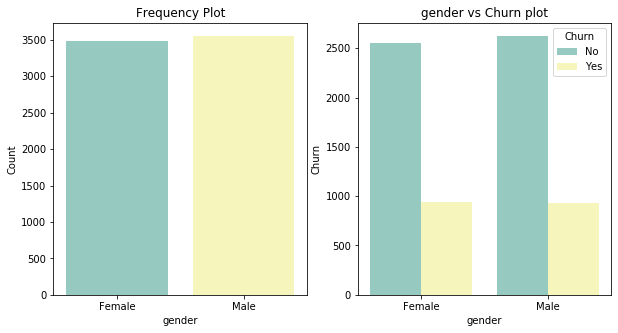

In [0]:
# univariant analyis on MultipleLines
category_plot(telecom_df.gender,telecom_df.Churn)

In [0]:

df_data=telecom_df.copy()
df_data.dropna()
df_data.loc [df_data.Churn == 'No', 'Churn'] = 0 
df_data.loc [df_data.Churn == 'Yes', 'Churn'] = 1
df_data.groupby('gender').Churn.mean()



gender
Female    939
Male      930
Name: Churn, dtype: int64

Les clients féminins sont plus susceptibles de se désabonnement que les clients masculins, mais la différence est minime (~ 0,8%).

Reproduisons cela pour toutes les colonnes catégorielles.

**Service Internet**

col_0 InternetService  count  percent(%)
0                 DSL   2421       34.38
1         Fiber optic   3095       43.95
2                  No   1526       21.67


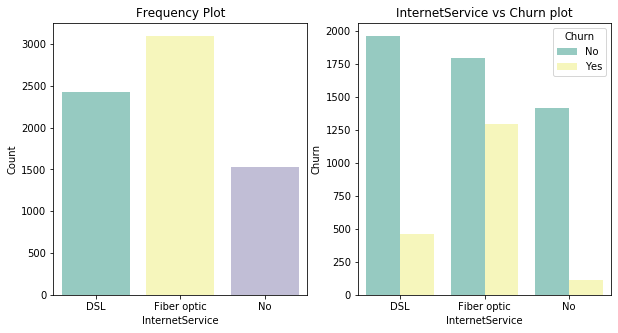

In [0]:
# univariant analyis on InternetServices
category_plot(telecom_df.InternetService,telecom_df.Churn)

Ce graphique révèle que les clients qui utilisent la fibre optique comme service Internet sont plus susceptibles de se désengager. Je m'attends normalement à ce que les clients en fibre optique produisent moins parce qu'ils utilisent un service plus premium. Mais cela peut se produire en raison de prix élevés, de la concurrence, du service client et de nombreuses autres raisons.

**Contrat**

col_0        Contract  count  percent(%)
0      Month-to-month   3875       55.03
1            One year   1473       20.92
2            Two year   1694       24.06


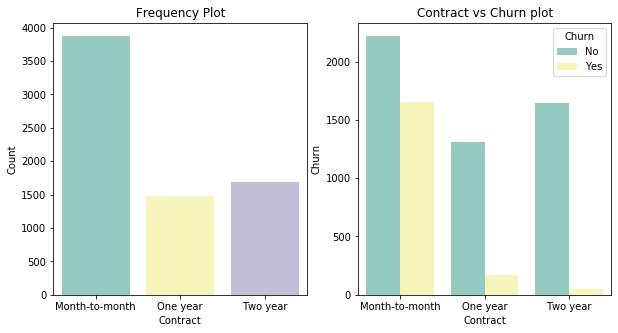

In [0]:
# univariant analyis on Contract
category_plot(telecom_df.Contract, telecom_df.Churn)

Le contrat plus court à un taux de désabonnement plus élevé.

**Support technique**

col_0          TechSupport  count  percent(%)
0                       No   3473       49.32
1      No internet service   1526       21.67
2                      Yes   2043       29.01


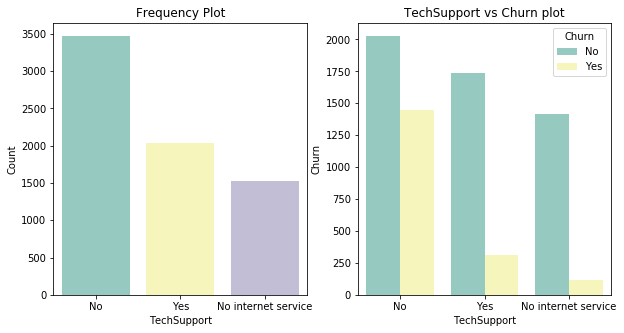

In [0]:
# univariant analyis on TechSupport
category_plot( telecom_df.TechSupport,telecom_df.Churn)

In [0]:
df_data=telecom_df.copy()
df_data.loc [df_data.Churn == 'No', 'Churn'] = 0 
df_data.loc [df_data.Churn == 'Yes', 'Churn'] = 1
df_data.groupby('TechSupport').Churn.mean()

TechSupport
No                     0.416355
No internet service    0.074050
Yes                    0.151738
Name: Churn, dtype: float64

Les clients n'utilisant pas le support technique sont plus enclins à un désabonnement (différence de ~ 26%).

**Mode de paiement**

col_0              PaymentMethod  count  percent(%)
0      Bank transfer (automatic)   1543       21.91
1        Credit card (automatic)   1522       21.61
2               Electronic check   2365       33.58
3                   Mailed check   1612       22.89


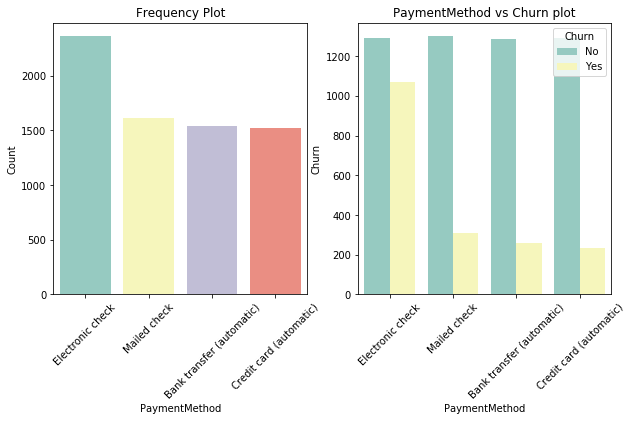

In [0]:
# univariant analyis on PaymentMethod
category_plot(telecom_df.PaymentMethod, telecom_df.Churn, h_v='v')

In [0]:
df_data=telecom_df.copy()
df_data.loc [df_data.Churn == 'No', 'Churn'] = 0 
df_data.loc [df_data.Churn == 'Yes', 'Churn'] = 1
df_data.groupby('PaymentMethod').Churn.mean()

PaymentMethod
Bank transfer (automatic)    0.167207
Credit card (automatic)      0.152431
Electronic check             0.452854
Mailed check                 0.191067
Name: Churn, dtype: float64

L'automatisation du paiement rend le client plus susceptible de conserver son abonnement (~ 30% de différence).

**Autres**

col_0 PaperlessBilling  count  percent(%)
0                   No   2872       40.78
1                  Yes   4170       59.22


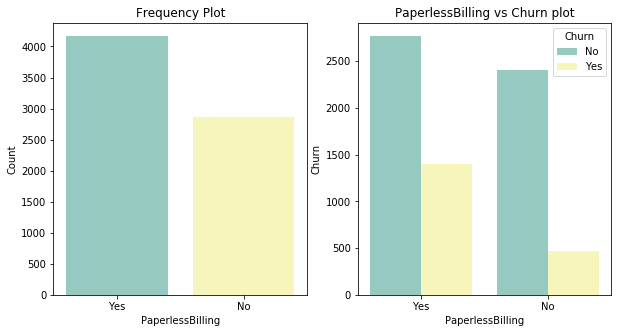

In [0]:
# univariant analyis on PaperlessBilling
category_plot(telecom_df.PaperlessBilling, telecom_df.Churn)

col_0      StreamingMovies  count  percent(%)
0                       No   2785       39.55
1      No internet service   1526       21.67
2                      Yes   2731       38.78


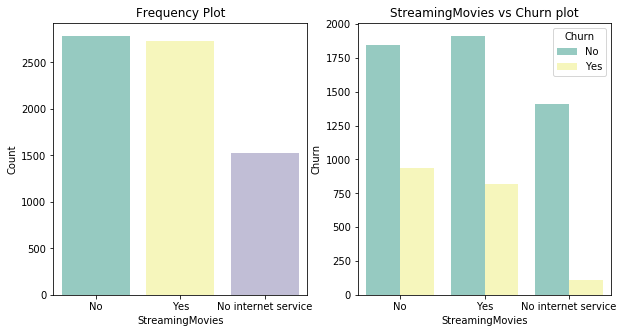

In [0]:
# univariant analyis on StreamingMovies
category_plot(telecom_df.StreamingMovies, telecom_df.Churn)

col_0     DeviceProtection  count  percent(%)
0                       No   3095       43.95
1      No internet service   1526       21.67
2                      Yes   2421       34.38


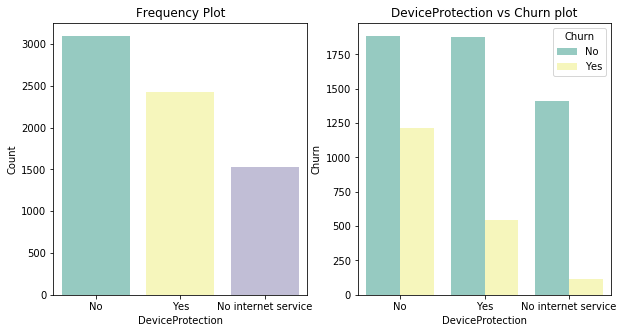

In [0]:
# univariant analyis on DeviceProtection
category_plot(telecom_df.DeviceProtection,telecom_df.Churn)

col_0 PhoneService  count  percent(%)
0               No    682        9.68
1              Yes   6360       90.32


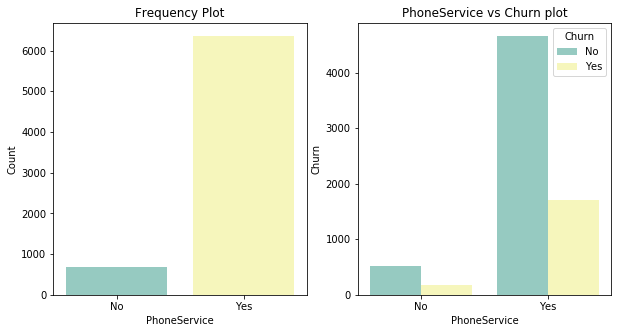

In [0]:
# univariant analyis on PhoneService
category_plot(telecom_df.PhoneService,telecom_df.Churn)

Nous en avons terminé avec les fonctionnalités catégoriques. Voyons à quoi ressemblent les caractéristiques numériques:

**Ancienneté**

Pour voir la tendance entre l'ancienneté et le taux de désabonnement moyen, construisons un nuage de points:

Text(0, 0.5, 'Churn Rate')

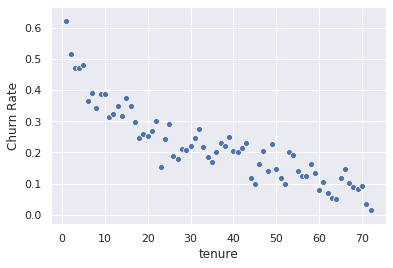

In [0]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(x="tenure", y="Churn", data=df_data.groupby('tenure').Churn.mean().reset_index())
plt.ylabel('Churn Rate')

Super évident qu'une ancienneté plus élevée signifie un taux de désabonnement inférieur. Nous allons appliquer la même chose pour les frais mensuels et totaux

Text(0, 0.5, 'Churn Rate')

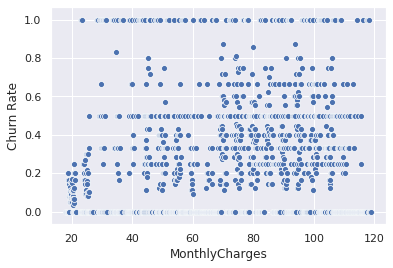

In [0]:
ax = sns.scatterplot(x="MonthlyCharges", y="Churn", data=df_data.groupby('MonthlyCharges').Churn.mean().reset_index())
plt.ylabel('Churn Rate')

In [0]:
df_data[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull()]
df_data.loc[pd.to_numeric(df_data['TotalCharges'], errors='coerce').isnull(),'TotalCharges'] = np.nan
df_data = df_data.dropna()
df_data['TotalCharges'] = pd.to_numeric(df_data['TotalCharges'], errors='coerce')


Text(0, 0.5, 'Churn Rate')

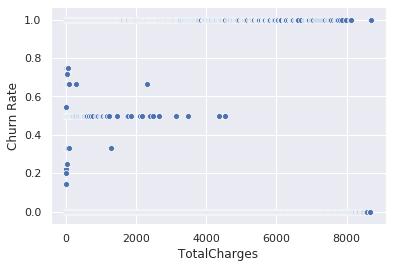

In [0]:

ax = sns.scatterplot(x="TotalCharges", y="Churn", data=df_data.groupby('TotalCharges').Churn.mean().reset_index())
plt.ylabel('Churn Rate')

il n'y a aucune tendance entre le taux de désabonnement et les frais mensuels et totaux.




Ingénierie des fonctionnalités
Dans cette section, nous allons transformer nos fonctionnalités brutes pour en extraire plus d'informations. Notre stratégie est la suivante:

1- Regroupez les colonnes numériques en utilisant des techniques de clustering

2- Appliquer Label Encoder à des fonctionnalités catégorielles binaires

3- Appliquer get_dummies () aux entités catégorielles qui ont plusieurs valeurs

**Colonnes numériques**

Comme nous le savons dans la section EDA, nous avons trois colonnes numériques:

* Ancienneté(Tenure) 
* Frais mensuels(MonthlyCharges)
* Charges totales(TotalCharges)

Nous allons appliquer les étapes suivantes pour créer des groupes:

* Utilisation de la méthode du coude pour identifier le nombre approprié de grappes
* Appliquer la logique K-means à la colonne sélectionnée et modifier le nom
* Observer le profil des clusters

Vérifions comment cela fonctionne dans la pratique:
Profils de cluster:

In [0]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

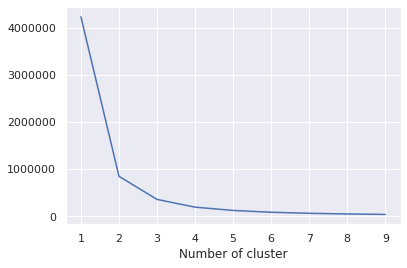

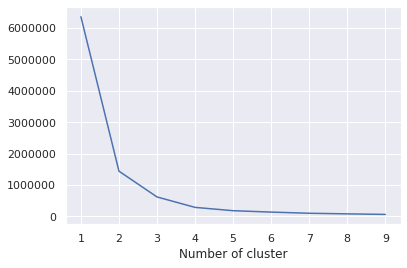

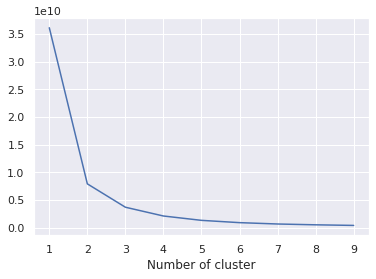

In [0]:
####################tenure
sse={}
df_cluster = df_data[['tenure']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()


####################MonthlyCharges
sse={}
df_cluster = df_data[['MonthlyCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

####################TotalCharges
sse={}
df_cluster = df_data[['TotalCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()




**Taux de désabonnement par groupe d'ncienneté**

In [0]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['tenure']])
df_data['TenureCluster'] = kmeans.predict(df_data[['tenure']])

In [0]:
df_data = order_cluster('TenureCluster', 'tenure',df_data,True)

In [0]:
df_data.groupby('TenureCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster,,,,,,,,
0,2867.0,7.541332,5.970615,1.0,2.0,6.0,12.0,20.0
1,1926.0,33.854102,8.208706,21.0,26.0,34.0,41.0,48.0
2,2238.0,63.047364,7.479639,49.0,56.0,64.0,70.0,72.0


Nous avons 3 grappes avec 7,5, 33,9 et 63 comme durée moyenne.

Taux de désabonnement pour chaque cluster:


In [0]:
df_data['TenureCluster'] = df_data["TenureCluster"].replace({0:'Low',1:'Mid',2:'High'})

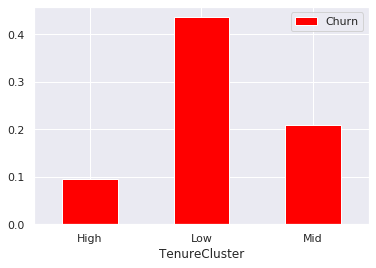

In [0]:
data=df_data.groupby('TenureCluster').Churn.mean().reset_index()
ax = data.plot.bar(x='TenureCluster', y='Churn', rot=0, color='red')

Voici à quoi cela ressemble après avoir appliqué la même chose pour les frais mensuels et totaux:

**Taux de désabonnement par groupe de frais mensuels**

In [0]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['MonthlyCharges']])
df_data['MonthlyChargesCluster'] = kmeans.predict(df_data[['MonthlyCharges']])

df_data = order_cluster('MonthlyChargesCluster', 'MonthlyCharges',df_data,True)
df_data.groupby('MonthlyChargesCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
MonthlyChargesCluster,,,,,,,,
0,1886.0,28.777306,23.809951,1.0,7.0,23.0,49.0,72.0
1,2235.0,25.976734,23.377089,1.0,4.0,18.0,46.0,72.0
2,2910.0,39.722337,23.976926,1.0,17.0,41.0,63.0,72.0


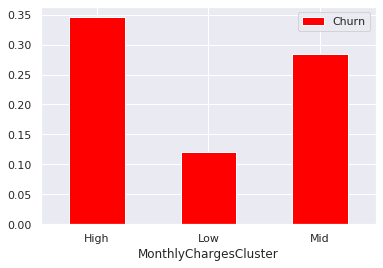

In [0]:
df_data['MonthlyChargesCluster'] = df_data["MonthlyChargesCluster"].replace({0:'Low',1:'Mid',2:'High'})

data=df_data.groupby('MonthlyChargesCluster').Churn.mean().reset_index()
ax = data.plot.bar(x='MonthlyChargesCluster', y='Churn', rot=0, color='red')

**Taux de désabonnement par groupe de charges totals**

In [0]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['TotalCharges']])
df_data['TotalChargesCluster'] = kmeans.predict(df_data[['TotalCharges']])

df_data = order_cluster('TotalChargesCluster', 'TotalCharges',df_data,True)
df_data.groupby('TotalChargesCluster').tenure.describe()

,count,mean,std,min,25%,50%,75%,max
TotalChargesCluster,,,,,,,,
0,4142.0,18.169000,19.203493,1.0,3.0,12.0,24.0,72.0
1,1611.0,43.769088,13.403256,19.0,33.0,42.0,53.0,72.0
2,1278.0,64.284820,7.517681,43.0,59.0,66.0,71.0,72.0


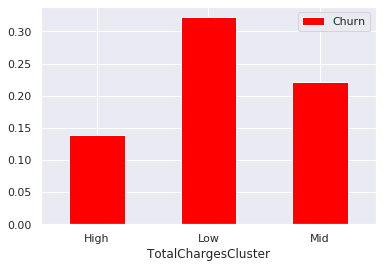

In [0]:
df_data['TotalChargesCluster'] = df_data["TotalChargesCluster"].replace({0:'Low',1:'Mid',2:'High'})

data=df_data.groupby('TotalChargesCluster').Churn.mean().reset_index()
ax = data.plot.bar(x='TotalChargesCluster', y='Churn', rot=0, color='red')

**Colonnes catégorielles**

Label Encoder convertit les colonnes catégorielles en numériques en attribuant simplement des entiers à des valeurs distinctes. Par exemple, le sexe de la colonne a deux valeurs: féminin et masculin . L'encodeur d'étiquettes le convertira en 1 et 0.


La méthode get_dummies () crée de nouvelles colonnes à partir des colonnes catégorielles en attribuant 0 et 1 (vous pouvez trouver l'explication exacte dans notre article précédent )


In [0]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7031 entries, 0 to 7030
Data columns (total 24 columns):
customerID               7031 non-null object
MultipleLines            7031 non-null object
InternetService          7031 non-null object
OnlineSecurity           7031 non-null object
OnlineBackup             7031 non-null object
DeviceProtection         7031 non-null object
TechSupport              7031 non-null object
StreamingTV              7031 non-null object
StreamingMovies          7031 non-null object
gender                   7031 non-null object
SeniorCitizen            7031 non-null int64
Partner                  7031 non-null object
Dependents               7031 non-null object
tenure                   7031 non-null int64
PhoneService             7031 non-null object
Contract                 7031 non-null object
PaperlessBilling         7031 non-null object
PaymentMethod            7031 non-null object
MonthlyCharges           7031 non-null float64
TotalCharges        

In [0]:
#import Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns

for column in df_data.columns:
    if df_data[column].dtype == object and column != 'customerID':
        if df_data[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df_data[column] = le.fit_transform(df_data[column]) 
        else:
            dummy_columns.append(column)

#apply get dummies for selected columns
df_data = pd.get_dummies(data = df_data,columns = dummy_columns)

In [0]:
df_data[['gender','Partner','TenureCluster_High','TenureCluster_Low','TenureCluster_Mid']].head()

,gender,Partner,TenureCluster_High,TenureCluster_Low,TenureCluster_Mid
0,0,1,0,1,0
1,0,0,0,1,0
2,1,0,0,1,0
3,1,0,0,1,0
4,1,1,0,1,0


les colonnes sexe et partenaire sont devenues numériques, et nous avons trois nouvelles colonnes pour TenureCluster .

Il est temps d'adapter un modèle de régression logistique et d'extraire des informations pour prendre de meilleures décisions commerciales.

##**Régression logistique**

La prédiction du taux de désabonnement est un problème de classification binaire. Les clients se désabonnent ou conservent dans une période donnée. En plus d'être un modèle robuste, la régression logistique fournit également des résultats interprétables. Nous allons trier nos étapes à suivre pour créer un modèle de régression logistique:

* Préparer les données (entrées pour le modèle)
* Monter le modèle et voir le résumé du modèle

In [0]:
all_columns = []
for column in df_data.columns:
    column = column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_")
    all_columns.append(column)

df_data.columns = all_columns

In [0]:
glm_columns = 'gender'

for column in df_data.columns:
    if column not in ['Churn','customerID','gender']:
        glm_columns = glm_columns + ' + ' + column

In [0]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
 

glm_model = smf.glm(formula='Churn ~ {}'.format(glm_columns), data=df_data, family=sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Churn   No. Observations:                 7031
Model:                            GLM   Df Residuals:                     7001
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2900.5
Date:                Fri, 14 Feb 2020   Deviance:                       5801.0
Time:                        17:16:54   Pearson chi2:                 7.55e+03
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

Nous avons deux résultats importants de ce rapport. Lorsque nous préparons un modèle de prédiction de désabonnement, nous somme confronté aux questions ci-dessous:
* 1- Quelles fonctionnalité poussent au desabonnement ou retiennent les clients?
* 2- Quels sont les plus critiques? Sur quoi devrions-nous nous concentrer?

Pour la première question, vous devriez regarder la 4ème **colonne (P> | z |)**. Si la valeur de p absolue est inférieure à 0,05, cela signifie que cette fonction affecte le taux de désabonnement d'une manière statistiquement significative. par exemple

* SeniorCitizen
* InternetService_DSL
* OnlineSecurity_NO

Puis la deuxième question. Nous voulons réduire le taux de désabonnement, par où commencer? La version scientifique de cette question est;

Quelle fonctionnalité apportera le meilleur retour sur investissement si j'augmente / diminue d'une unité?

on peut répondre à cette question en consultant **la colonne coef** 

On peut observer que certaines variables ont une relation positive avec notre variable prédite et certaines ont une relation négative. Une valeur positive a un impact positif sur notre variable prédite. Un bon exemple est «Contract_Month-to-month»: la relation positive avec le taux de désabonnement signifie que le fait d'avoir ce type de contrat augmente également la probabilité qu'un client se désabonne de ~76,51% qui correspond à une variation de 2,15 environs du taux de desabonnement une augme.  D'un autre côté, «Contract_Two year» est dans une relation très négative avec la variable prévue, ce qui signifie que les clients avec ce type de contrat sont très peu susceptibles de se désabonner.

 
 Le coef exponentiel nous donne la variation attendue du taux de désabonnement si nous la modifions d'une unité. Si nous appliquons le code ci-dessous, nous verrons la version transformée de tous les coefficients:

In [0]:
np.exp(res.params)

Intercept                                  1.268943
gender                                     0.975563
SeniorCitizen                              1.251743
Partner                                    1.001338
Dependents                                 0.873760
tenure                                     0.939485
PhoneService                               1.236084
PaperlessBilling                           1.418250
MonthlyCharges                             0.967679
TotalCharges                               1.000119
MultipleLines_No                           0.886495
MultipleLines_No_phone_service             1.026583
MultipleLines_Yes                          1.394349
InternetService_DSL                        0.552503
InternetService_Fiber_optic                2.787983
InternetService_No                         0.823792
OnlineSecurity_No                          1.378487
OnlineSecurity_No_internet_service         0.823792
OnlineSecurity_Yes                         1.117434
OnlineBackup

À partir du tableau ci-dessus, nous pouvons identifier rapidement les fonctionnalités les plus importantes.

##**Modèle de classification binaire avec XGBoost**

Pour adapter XGBoost à nos données, nous devons préparer les ensembles d'entités (X) et d'étiquettes (y) et faire la répartition des trains et des tests.

In [0]:
#create feature set and labels
X = df_data.drop(['Churn','customerID'],axis=1)
y = df_data.Churn
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)
#building the model & printing the score
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.84
Accuracy of XGB classifier on test set: 0.82


En utilisant ce modèle simple, nous avons atteint une précision de 82%

In [0]:
y_pred = xgb_model.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))

[[238  20]
 [ 42  52]]


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       258
           1       0.72      0.55      0.63        94

    accuracy                           0.82       352
   macro avg       0.79      0.74      0.76       352
weighted avg       0.82      0.82      0.82       352



Notre modèle predit 70/100 client qui se sont reellement désabonnés  et 55/100 clients sont 

La précision et le rappel sont acceptables pour 0. Par exemple, pour  0 (no churn), si le modèle prédit des client qui ne se désabonne pas, 0,85 sur 100 seront corrects (précision). Et le modèle identifie avec succès 92% des clients qui ne se sont pas réellement désabonné 0 (rappel). Nous devons vraiment améliorer le modèle pour 1 (churn). Par exemple, nous détectons 72% des clients qui se désabonne et le modèle identifie avec succès 55% des clients qui se désabonnes Actions possibles pour améliorer ces points:

* Ajouter plus de fonctionnalités et améliorer l'ingénierie des fonctionnalités
Essayez différents modèles autres que XGBoost
Appliquer un réglage hyper paramétrique au modèle actuel
* Ajoutez plus de données au modèle si possible



Voyons comment notre modèle fonctionne en détail. Tout d'abord, nous voulons savoir quelles fonctionnalités notre modèle utilise exactement à partir de l'ensemble de données. Quelles étaient également les plus importantes?
Pour répondre à cette question, nous pouvons utiliser le code ci-dessous:

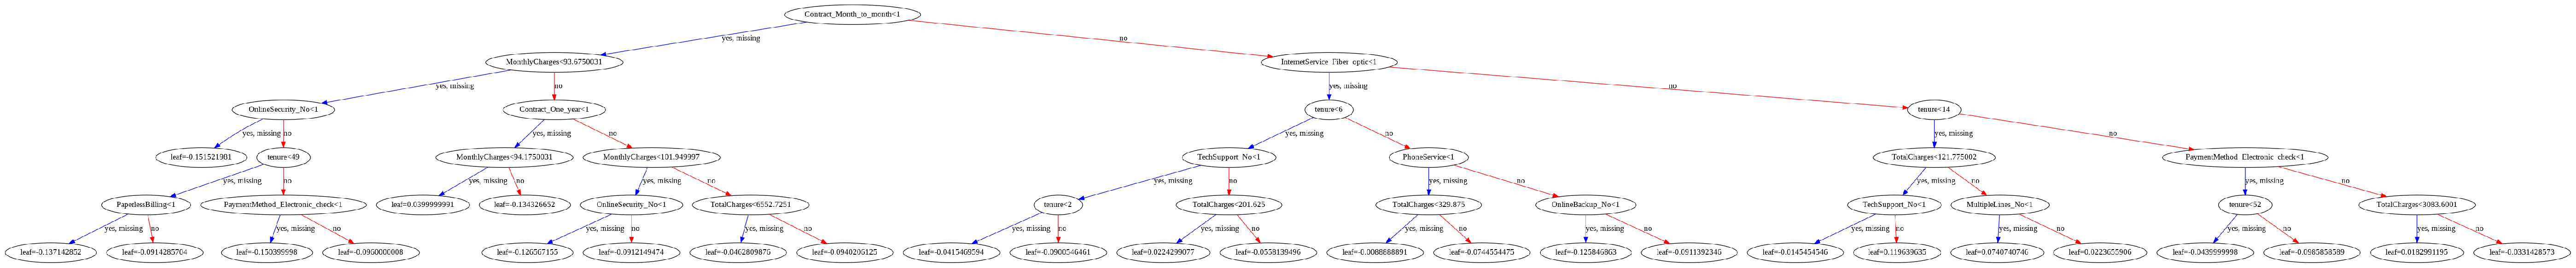

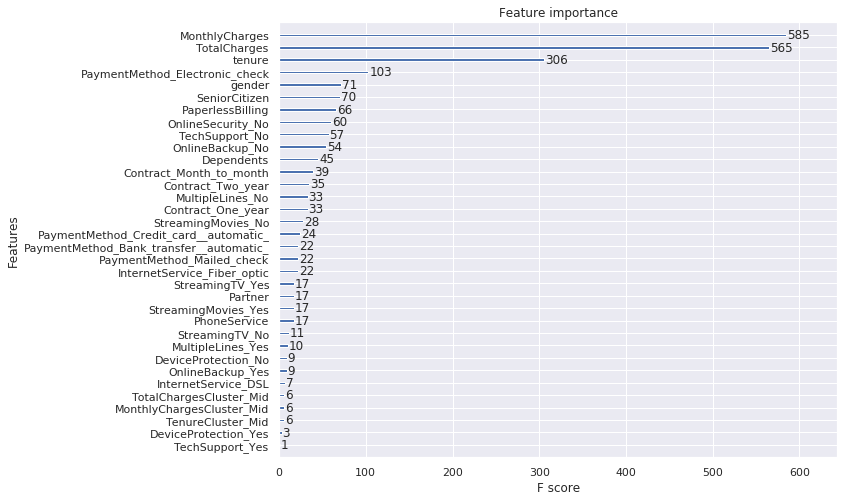

In [0]:
from xgboost import plot_tree

##set up the parameters
fig, ax = plt.subplots(figsize=(100,100))
plot_tree(xgb_model, ax=ax)


1/(1+np.exp(-0.032))

from xgboost import plot_importance

from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

Nous pouvons voir que notre modèle accorde plus d'importance aux TotalCharges et MonthlyCharges qu'aux autres.
Enfin, la meilleure façon d'utiliser ce modèle consiste à attribuer la probabilité de désabonnement à chaque client, à créer des segments et à élaborer des stratégies en plus de cela. Pour obtenir la probabilité de désabonnement de notre modèle, utilisons le bloc de code ci-dessous:

In [0]:
# print the first 10 predicted probabilities for class 1 avec le seuil par defaut 0.5
from sklearn.preprocessing import binarize
df_data['proba'] = xgb_model.predict_proba(df_data[X_train.columns])[:,1]
df_data['pred'] = binarize([df_data['proba']], 0.5)[0]


In [0]:
df_data[['customerID', 'proba','pred']].head()

,customerID,proba,pred
0,7590-VHVEG,0.598682,1.0
1,6713-OKOMC,0.152362,0.0
2,7469-LKBCI,0.017008,0.0
3,8779-QRDMV,0.902979,1.0
4,1680-VDCWW,0.035115,0.0


Diminuons le seuil de prédiction du désabonnement afin d'augmenter la sensibilité du classifieur

In [0]:
# prédire désabonnement si la probabilité prévue est supérieure à 0,1
df_data['pred'] = binarize([df_data['proba']], 0.1)[0]
df_data[['customerID', 'proba','pred']].head()

,customerID,proba,pred
0,7590-VHVEG,0.598682,1.0
1,6713-OKOMC,0.152362,1.0
2,7469-LKBCI,0.017008,0.0
3,8779-QRDMV,0.902979,1.0
4,1680-VDCWW,0.035115,0.0


Nous pouvons manipulé nos probabilités comme bon nous sembles. ci dessous le code pour voir comment se comporte nos donné de test si nous modifions la probabilité de 0.5 defaut à 0.3

In [0]:
# store the predicted probabilities for class 1
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

In [0]:
# prédire désabonnementsi la probabilité prévue est supérieure à 0,3
from sklearn.preprocessing import binarize
y_pred = binarize([y_pred_prob], 0.3)[0]

In [0]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(y_test, y_pred))

[[209  49]
 [ 19  75]]


In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86       258
           1       0.60      0.80      0.69        94

    accuracy                           0.81       352
   macro avg       0.76      0.80      0.77       352
weighted avg       0.83      0.81      0.81       352



Nous pouvons voir la sensibilité(recall) de notre modèle s'amélioré de 0.55 à 0.80 il est toujour bon d'avoir une fausse alerte incendie  que d'avoir une fausse alerte tout vas bien :-)